<a href="https://colab.research.google.com/github/Mike-Ziegler/MANE_4962_PROJECT_SPRING24/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Random Forest Model: 100 trees, depth_limit of 10, and bagging classifier**

The Bagging Classifier, also known as bootstrap aggregating, improves the preditions made in the supervied learning algorythm that combines preditions from the decision trees. These data sets have 22320 rows with 13 colums of collected data and 8 columns of extracted deep features using a CAE.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the training data
train_file = "CAE1_32_64_20_512_8_10_20.xlsx"
df_train = pd.read_excel(train_file, header=[0, 1])
X_train = df_train.iloc[:, :-1]  # Using all features except the last one
y_train = df_train['Class', 'labels_bio-0_cfe-1']

# Load and preprocess the testing data
test_file = "CAE2_32_64_20_512_8_100_256.xlsx"
df_test = pd.read_excel(test_file, header=[0, 1])

# Ensure test data has the same columns as train data
common_columns = df_train.columns.intersection(df_test.columns)
X_test = df_test[common_columns]  # Only use common columns in the test set
y_test = df_test['Class', 'labels_bio-0_cfe-1']

# Load the missing deep features (d1 to d8) from the original test data
missing_columns = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8']
for col in missing_columns:
    X_test[col] = df_test[col] if col in df_test.columns else 0  # Fill missing columns with 0

# Extract 'Class' column before standardizing features
y_test_original = X_test['Class', 'labels_bio-0_cfe-1']
X_test = X_test.drop(('Class', 'labels_bio-0_cfe-1'), axis=1)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# CAE hyperparameters for the two datasets
# For CAE1_32_64_20_512_8_10_20.xlsx
s1_cae1, s2_cae1, s3_cae1, s4_cae1, s5_cae1, s6_cae1, s7_cae1 = 32, 64, 20, 512, 8, 10, 20

# For CAE2_32_64_20_512_8_100_256.xlsx
s1_cae2, s2_cae2, s3_cae2, s4_cae2, s5_cae2, s6_cae2, s7_cae2 = 32, 64, 20, 512, 8, 100, 256

# Create a base Random Forest model
base_model = RandomForestClassifier(n_estimators=1000, max_depth=500)

# Create a Bagging Random Forest model
bagging_model = BaggingClassifier(base_estimator=None, bootstrap=True, bootstrap_features=True,
                  max_features=0.8, max_samples=0.8, n_estimators=10,
                  n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                  warm_start=False)

# Train the Bagging Random Forest
bagging_model.fit(X_train_scaled, y_train)

# Get the best base model from the BaggingClassifier
best_base_model = bagging_model.base_estimator_

# Fit the best base model on the training data
best_base_model.fit(X_train_scaled, y_train)

# Predict on the test set using the best base model
y_pred = best_base_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test_original, y_pred)
print("Accuracy:", accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.7480625363974376


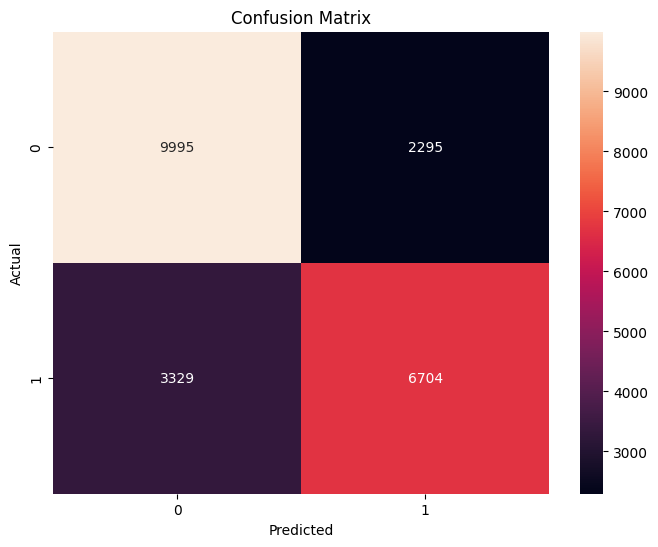

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(y_test_original, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Accuracy: 0.7480625363974376**

**Atempting to perform Grid Search for tuning random forest to improve accuracy**

**Grid search was unsucessful and timed out.**

**Trying random search**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Load and preprocess the data
def load_data(file_name):
    df = pd.read_excel(file_name, header=[0, 1])  # Load with multi-level header
    feature_names = df.columns.to_flat_index()[:-1]  # Get multi-level index (excluding last column)
    X = df.values[:, :-1]  # Features (remove the last column which is the class label)
    y = df.values[:, -1]   # Class labels (last column)
    return X, y, feature_names

def preprocess_data(X):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

# Load and preprocess the data
file_name = "CAE1_32_64_20_512_8_10_20.xlsx"
X, y, feature_names = load_data(file_name)
X_scaled = preprocess_data(X)

# Ensure X and y have the same number of samples
X, y = shuffle(X_scaled, y, random_state=42)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base Random Forest model
base_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, class_weight='balanced')

# Create the Bagging Classifier
bagging_model = BaggingClassifier(base_model, n_estimators=10, max_samples=0.8, max_features=0.8, random_state=42, bootstrap = True, bootstrap_features= True)

# Define the parameter grid to search
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_samples': [0.5, 0.7, 0.8],
    'max_features': [0.5, 0.7, 0.8],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],
    'base_estimator__max_depth': [5, 10, 20]
}

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(
    bagging_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = random_search.best_params_
best_score = random_search.best_score_

# Get the best model
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)
print("Test Set Score:", test_score)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:905: FutureWarning: Parameter 'base_estimator' of BaggingClassifier is deprecated in favor of 'estimator'. See BaggingClassifier's docstring for more details.
  clone(base_estimator).set_params(**self.best_params_)


Best Parameters: {'n_estimators': 300, 'max_samples': 0.7, 'max_features': 0.8, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator__max_depth': 20}
Best Cross-Validation Score: 0.8323997866049888
Test Set Score: 0.8360582306830907


**Recreating Random Seach Results to Validate**

**Best Parameters: {'n_estimators': 300, 'max_samples': 0.7, 'max_features': 0.8, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator__max_depth': 20}**

**Best Cross-Validation Score: 0.8323997866049888**

**Test Set Score: 0.8360582306830907**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `base_estimator_` was deprecated in version 1.2 and will be removed in 1.4. Use `estimator_` instead.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 0.8163329301617166


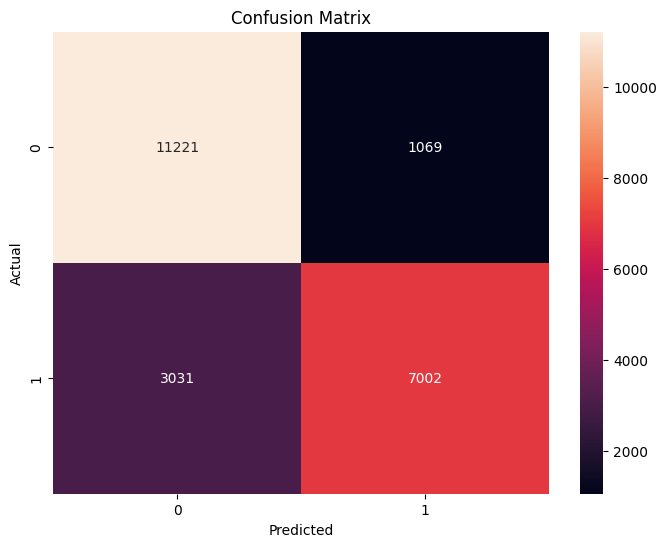

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the training data
train_file = "CAE1_32_64_20_512_8_10_20.xlsx"
df_train = pd.read_excel(train_file, header=[0, 1])
X_train = df_train.iloc[:, :-1]  # Using all features except the last one
y_train = df_train['Class', 'labels_bio-0_cfe-1']

# Load and preprocess the testing data
test_file = "CAE2_32_64_20_512_8_100_256.xlsx"
df_test = pd.read_excel(test_file, header=[0, 1])

# Ensure test data has the same columns as train data
common_columns = df_train.columns.intersection(df_test.columns)
X_test = df_test[common_columns]  # Only use common columns in the test set
y_test = df_test['Class', 'labels_bio-0_cfe-1']

# Load the missing deep features (d1 to d8) from the original test data
missing_columns = ['d1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8']
for col in missing_columns:
    X_test[col] = df_test[col] if col in df_test.columns else 0  # Fill missing columns with 0

# Extract 'Class' column before standardizing features
y_test_original = X_test['Class', 'labels_bio-0_cfe-1']
X_test = X_test.drop(('Class', 'labels_bio-0_cfe-1'), axis=1)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# CAE hyperparameters for the two datasets
# For CAE1_32_64_20_512_8_10_20.xlsx
s1_cae1, s2_cae1, s3_cae1, s4_cae1, s5_cae1, s6_cae1, s7_cae1 = 32, 64, 20, 512, 8, 10, 20

# For CAE2_32_64_20_512_8_100_256.xlsx
s1_cae2, s2_cae2, s3_cae2, s4_cae2, s5_cae2, s6_cae2, s7_cae2 = 32, 64, 20, 512, 8, 100, 256

#Best Parameters found using random search n_estimators': 300, 'max_samples': 0.7, 'max_features': 0.8, 'bootstrap_features': False, 'bootstrap': True, 'base_estimator__max_depth': 20
# Define the base Random Forest model
base_model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, class_weight='balanced')

# Create the Bagging Classifier
bagging_model = BaggingClassifier(base_model, n_estimators=300, max_samples=0.7, max_features=0.8, random_state=42, bootstrap = True, bootstrap_features= False)

# Train the Bagging Random Forest
bagging_model.fit(X_train_scaled, y_train)

# Get the best base model from the BaggingClassifier
best_base_model = bagging_model.base_estimator_

# Fit the best base model on the training data
best_base_model.fit(X_train_scaled, y_train)

# Predict on the test set using the best base model
y_pred = best_base_model.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test_original, y_pred)
print("Accuracy:", accuracy)
# Plot confusion matrix
cm = confusion_matrix(y_test_original, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

**Results Similar with 81% accuracy**

**Looking at feature importance**

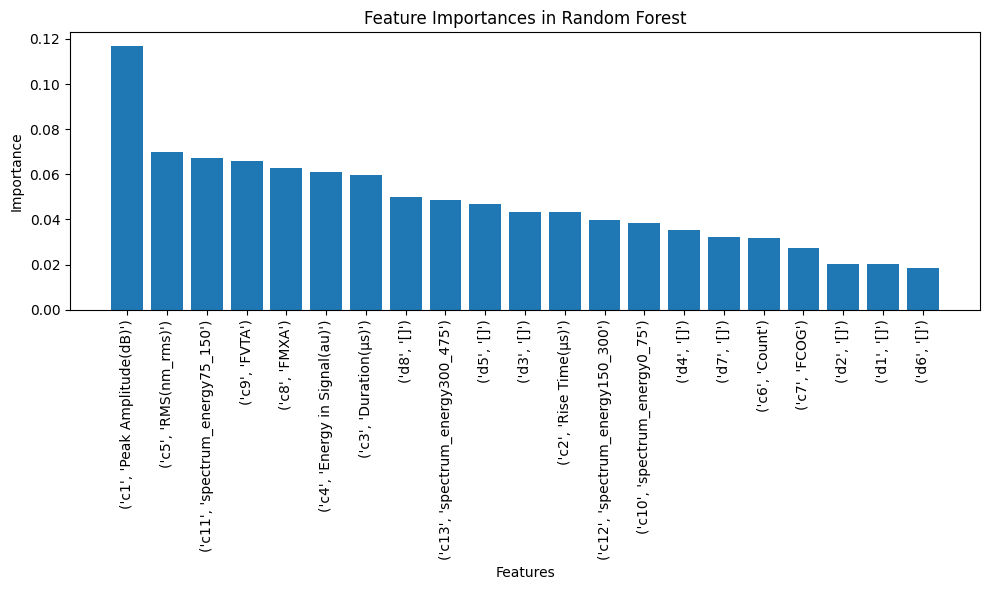

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the trained Random Forest model
feature_importances = rf_classifier.feature_importances_

# Get the names of the columns (features) from the original dataset
feature_names = df.columns[:-1]

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), sorted_feature_importances, align='center')
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.tight_layout()
plt.show()


**Increasing the number of trees to 100 and adjusting maximum depth limit**

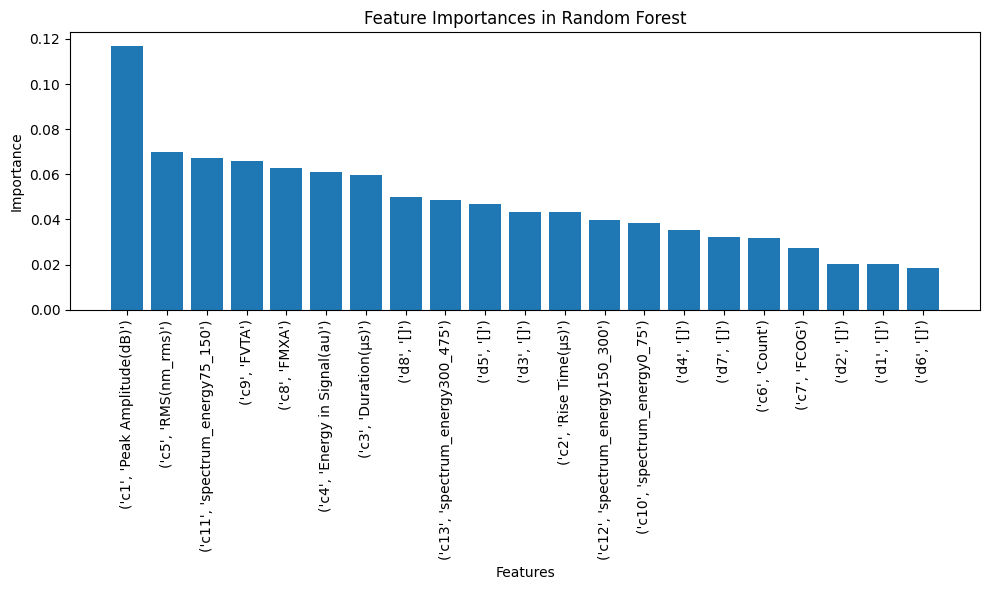

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# Load the dataset
file_name = "CAE1_32_64_20_512_8_10_20.xlsx"
df = pd.read_excel(file_name, header=[0, 1])

# Separate features and labels
X = df.values[:, :-1]  # Features (remove the last column which is the class label)
y = df.values[:, -1]   # Class labels (last column)

# Shuffle the dataset
X, y = shuffle(X, y, random_state=42)

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Create a Random Forest classifier with 100 trees and increased max depth
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# Get feature importances from the trained Random Forest model
feature_importances = rf_classifier.feature_importances_

# Get the names of the columns (features) from the original dataset
feature_names = df.columns[:-1]

# Sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), sorted_feature_importances, align='center')
plt.xticks(range(X_train.shape[1]), sorted_feature_names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in Random Forest')
plt.tight_layout()
plt.show()
from sklearn.metrics import confusion_matrix
import seaborn as sns

